In [2]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data

In [3]:
from sklearn.feature_selection import SelectKBest, chi2

### Read In Edge List and Transpose into COO Format

In [4]:
with open('edge_list/edge_index.txt') as edge_file:
    edges = []
    for line in edge_file.readlines():
        u, v, d = line.split()
        edges.append([int(u),int(v)])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

### Read in Data Matrix and Convert to Torch Tensor

$n x m$ matrix where $n$ is the number of states and $m$ is the number of search terms(features).

In [5]:
!ls hopkins_data/cleaned

2020-01-22.csv 2020-02-09.csv 2020-02-27.csv 2020-03-16.csv 2020-04-03.csv
2020-01-23.csv 2020-02-10.csv 2020-02-28.csv 2020-03-17.csv 2020-04-04.csv
2020-01-24.csv 2020-02-11.csv 2020-02-29.csv 2020-03-18.csv 2020-04-05.csv
2020-01-25.csv 2020-02-12.csv 2020-03-01.csv 2020-03-19.csv 2020-04-06.csv
2020-01-26.csv 2020-02-13.csv 2020-03-02.csv 2020-03-20.csv 2020-04-07.csv
2020-01-27.csv 2020-02-14.csv 2020-03-03.csv 2020-03-21.csv 2020-04-08.csv
2020-01-28.csv 2020-02-15.csv 2020-03-04.csv 2020-03-22.csv 2020-04-09.csv
2020-01-29.csv 2020-02-16.csv 2020-03-05.csv 2020-03-23.csv 2020-04-10.csv
2020-01-30.csv 2020-02-17.csv 2020-03-06.csv 2020-03-24.csv 2020-04-11.csv
2020-01-31.csv 2020-02-18.csv 2020-03-07.csv 2020-03-25.csv 2020-04-12.csv
2020-02-01.csv 2020-02-19.csv 2020-03-08.csv 2020-03-26.csv 2020-04-13.csv
2020-02-02.csv 2020-02-20.csv 2020-03-09.csv 2020-03-27.csv 2020-04-14.csv
2020-02-03.csv 2020-02-21.csv 2020-03-10.csv 2020-03-28.csv 2020-04-15.csv
2020-02-04.csv 2020-02-22

In [6]:
nodes_props = np.loadtxt('./datesprepped/2020-01-31.csv')
nodes_props

array([[ 0.,  0.,  0., ...,  0., 11.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 14.,  0., ...,  0., 10.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Get Hopkins Data Labels

In [7]:
# y = np.round(np.random.random(size=[51,1]) * 10) # randomly generate some cases for now
# y = torch.tensor(y, dtype=torch.float)
with open('./hopkins_data/cleaned/2020-01-31.csv') as fy:
    y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
y = torch.tensor(y_arr, dtype=torch.float).reshape([51, 1])

### Create Data Object

In [8]:
x = torch.tensor(nodes_props.tolist(), dtype=torch.float)
edge_index = edge_index
data = Data(x=x, y=y, edge_index=edge_index)

In [9]:
data.x.shape, data.y.shape

(torch.Size([51, 3243]), torch.Size([51, 1]))

In [10]:
x_new = SelectKBest(chi2, k=100).fit_transform(data.x, data.y.t().squeeze())
x_new.shape
# x_new = SelectKBest(chi2, k=100).fit_transform(x, data.y)
# print(x_new.shape)

(51, 100)

### Creating Dataloader

Now that we've created a single data object as an example we need to create a torch dataloader. This way we can batch multiple nodes together.

In [11]:
import os.path as osp
import os
from datetime import datetime, timedelta
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader


class COVIDSearchTerms(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(COVIDSearchTerms, self).__init__(root, transform, pre_transform)
        self.node_files = []
        self.target_files = []

    @property
    def raw_file_names(self):
        self.node_files = ['x/' + f for f in os.listdir('raw/x/')]
        self.node_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )
        # ensure that we only grab targets for dates we have
        self.target_files = [
            'y/' + f for f in
            list(set(os.listdir('raw/y/')) & set(os.listdir('raw/x/')))
        ]

        self.target_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )

        return self.node_files + self.target_files

    @property
    def processed_file_names(self):
        dates = os.listdir('raw/y/')
        return dates

    def download(self):
        pass
        # Download to `self.raw_dir`.

    def process(self):
        with open('edge_list/edge_index.txt') as edge_file:
            edges = []
            for line in edge_file.readlines():
                u, v, d = line.split()
                edges.append([int(u),int(v)])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        
        i = 0
        for node_file in self.node_files:
            date = node_file.split('/')[-1].split('.')[0]
            week_forward = datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=1)
            x = torch.tensor(np.loadtxt('raw/' + node_file).tolist(), dtype=torch.float)
            
            with open('raw/y/' + date + '.csv') as fy:
                hk_data_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            hk_data_arr = torch.tensor(hk_data_arr, dtype=torch.float).reshape([51, 1])
            
            x = torch.cat([x, hk_data_arr], dim=1)
            
            with open('raw/y/' + week_forward.strftime('%Y-%m-%d') + '.csv') as fy:
                y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            y = torch.tensor(y_arr, dtype=torch.float).reshape([1, 51])
            edge_index = edge_index
            # Read data from `raw_path`.
            data = Data(x=x, y=y, edge_index=edge_index)
            data.current_y = hk_data_arr

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            torch.save(data, osp.join(self.processed_dir, 'data-{}.pt'.format(i)))
            i = i + 1

    def len(self):
        return 57

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data-{}.pt'.format(idx)))
        return data

### Example Network Structure

In [12]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch_geometric.nn import TopKPooling, SAGEConv, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class GraphNetV1(torch.nn.Module):
    def __init__(self, convs=[(100,100), (100,100)], lin=[(100, 10), (10, 1)]):
        super(GraphNetV1, self).__init__()
        self.convolutions=torch.nn.ModuleList([GCNConv(*c) for c in convs])
        self.linear_layers=torch.nn.ModuleList([torch.nn.Linear(*l) for l in lin])
        self.activations=torch.nn.ModuleList([torch.nn.ReLU() for n in lin])
        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Normalize values?
        nm = torch.norm(x).detach()
        x = x.div(nm.expand_as(x))
                
        x = torch.tensor(
            SelectKBest(chi2, k=100).fit_transform(data.x, data.current_y.t().squeeze()),
            dtype=torch.float
        )
        # Run graph convolutions
        for gcon in self.convolutions:
            x = gcon(x, edge_index)
        
        # Run linear layers
        i = 0
        for lin, act in zip(self.linear_layers, self.activations):
            x = lin(x)
            if i < len(self.linear_layers)-1:
                x = act(x)
            else:
                break
            i = i + 1
        
        # Transpose x on the return?
        return x.t()

### Example feed forward of the network

In [13]:
dataset = COVIDSearchTerms('.')

Processing...
Done!


In [18]:
def train():
    model.train()

    losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).reshape((10,51))
#         print(output.reshape((10, 51)).shape)
#         print(data.y.shape)
        label = data.y.to(device)
        loss = crit(output, label)
        losses.append(loss)
        loss.backward()
#         loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return losses

batch_size=10
train_data = dataset[:50]
valid_data = dataset[50:]
device = torch.device('cpu')
# model = GraphNetV1(
#     convs=[(100, 100), (100, 100), (100, 100)],
#     lin=[(100, 100), (100, 100), (100, 75), (75, 50), 
#          (50, 50), (50, 25), (25, 10), (10, 5), (5, 1)]
# ).to(device)

model = GraphNetV1(
    convs=[],
    lin=[(100, 100), (100, 100), (100, 75), (75, 50), 
         (50, 50), (50, 25), (25, 10), (10, 5), (5, 1)]
).to(device)
# RENet(num_nodes, num_rels, hidden_channels, seq_len, num_layers=1, dropout=0.0, bias=True)
# model = torch_geometric.nn.RENet(51, edge_index.shape[-1], 100, 20, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.L1Loss()
train_loader = DataLoader(train_data, batch_size=batch_size)


losses = []
i = 1
for epoch in range(10):
    losses.append(train())
    print((i / 10) * 100)
    i = i + 1

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


(10,)


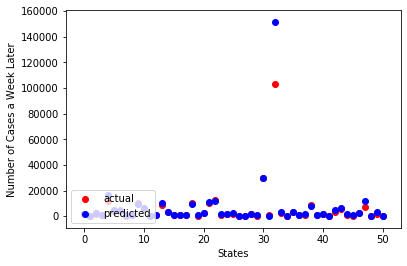

(10,)


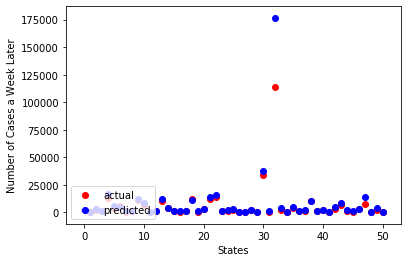

(10,)


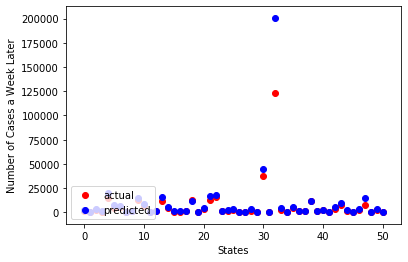

(10,)


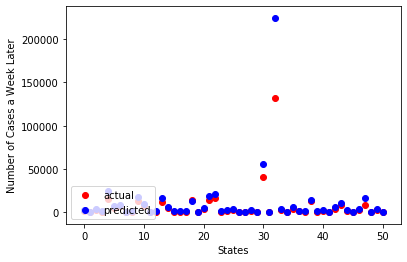

(9,)


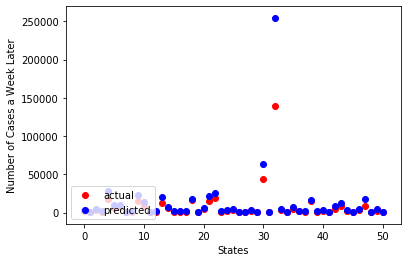

(10,)


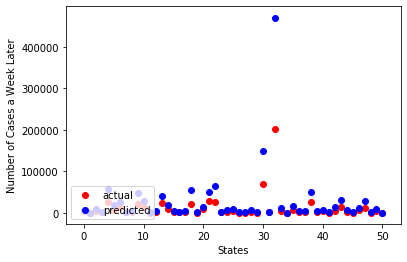

(9,)


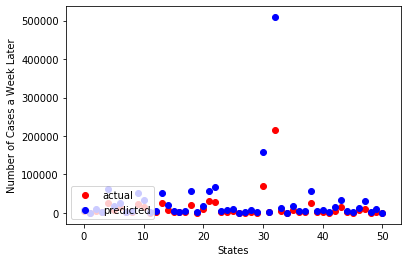

In [20]:
import matplotlib.pyplot as plt

dataset = COVIDSearchTerms('.')
valid_data = dataset[50:]
device = torch.device('cpu')
validation_loader = DataLoader(valid_data, batch_size=1)
for data in validation_loader:
    output = model(data).detach().numpy().squeeze()
    label = data.y.to(device).numpy().squeeze()
    top10_act = (-label).argsort()[:10]
    top10_pred = (-output).argsort()[:10]
    print(np.intersect1d(top10_act, top10_pred).shape)
    plt.scatter(np.arange(51), label, c="r", label="actual")
    plt.scatter(np.arange(51), output, c="b", label="predicted")
    plt.xlabel("States")
    plt.ylabel("Number of Cases a Week Later")
    plt.legend(loc="lower left")
    plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
i = 0
for data in train_loader:
    x = torch.sum(data.x, dim=1)
    y = data.y
    i = i + 1
    if i == 30:
        print(x.shape, torch.squeeze(y).shape)
        plt.scatter(x, y)
        plt.xlabel('Term Score - Summed Term Counts')
        plt.ylabel('Number of Cases - A Week Later')
        plt.show()
    else:
        continue

In [ ]:
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = torch.nn.Linear(51, 51)
        self.act1 = torch.nn.Tanh()
        self.lin2 = torch.nn.Linear(51, 51)
        self.act2 = torch.nn.ReLU()
        self.lin3 = torch.nn.Linear(51, 51)

    def forward(self, data):
        # Aggregate feature counts
        x = torch.sum(data.x, dim=1)
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x
    
model = Net().to(device)
crit = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for i in range(0, 200):
    for data in train_loader:
        output = model(data)
        label = torch.squeeze(data.y).to(device)
        loss = crit(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print("Finished epoch...", i)

In [ ]:
i = 0
for data in train_loader:
    i = i + 1
    if i == 30:
        x = torch.sum(data.x, dim=1)
        predict = model(data).detach()
        lab = torch.squeeze(data.y)
        print(predict, lab)
        plt.scatter(x, lab.numpy(), c="r", label="actual")
        plt.scatter(x, predict.numpy(), c="b", label="predicted")
        plt.xlabel("Term Count Score -- Summed Terms")
        plt.ylabel("Number of Cases a Week Later")
        plt.legend(loc="lower left")
        plt.show()
    else:
        continue

In [ ]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch.nn import LSTM
from torch_geometric.nn import TopKPooling, SAGEConv, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = torch.nn.Linear(feature_dim+1, 2000)
        self.act1 = torch.nn.ReLU()
        
        self.lin2 = torch.nn.Linear(2000, 1000)
        self.act2 = torch.nn.ReLU()
        
        self.lin3 = torch.nn.Linear(1000, 500)
        self.act3 = torch.nn.ReLU() 
        
        self.lin4 = torch.nn.Linear(500, 250)
        self.act4 = torch.nn.ReLU()
        
        self.lin5 = torch.nn.Linear(250, 100)
        self.act5 = torch.nn.ReLU()
        
        self.lin6 = torch.nn.Linear(100, 10)
        self.act6 = torch.nn.ReLU()
        
        self.lin7 = torch.nn.Linear(10, 1)
        self.act7 = torch.nn.ReLU()

        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        nm = torch.norm(x).detach()
        x = x.div(nm.expand_as(x))
        
        x = self.lin1(x)
        x = self.act1(x)
        
        x = self.lin2(x)
        x = self.act2(x)
        
        x = self.lin3(x)
        x = self.act3(x)
        
        x = self.lin4(x)
        x = self.act4(x)
        
        x = self.lin5(x)
        x = self.act5(x)
        
        x = self.lin6(x)
        x = self.act6(x)
        
        x = self.lin7(x)
        # shape of x will be 
        
        return x.t()